## Regret Analysis of OFL - \<Performance Experiments\>

### 1. Environment Setting

In [3]:
import  torch
import  numpy as np
import  matplotlib.pyplot as plt
from    keras import datasets
import  import_ipynb

from RegretBound import opt_param
from data import pull_data
from model import FL_Model

K = 1000        # Number of clients
D = 34826       # number of parameters
P = 0.01        # Com. overhead reduction rate from FedOGD
L = 1           # Local training time (Batch Size)

s, _, b, p = opt_param(P, D, show_result=False)

FedOGD_loss = []
OFedAvg_loss = []
OFedAQ_loss = []

FedOGD_acc = []
OFedAvg_acc = []
OFedAQ_acc = []

### 2. Experiment Setting

In [4]:
### Running Time (~2min, iMac 27(2019)) ###

#MNIST
x_train, y_train, _, _= pull_data()

FedOGD = FL_Model(K, False, 1, L)
OFedAvg = FL_Model(K, False, P, L)
#Synthetic data

2022-10-07 17:14:43.557923: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3. Training

#### 3-1. Classification



In [6]:
#OFedAvg iter 30 -> 3hr

for iter in range(10):
    for i in range(60):
        loss, acc = FedOGD.train(x_train[K*L*i : K*L*(i+1)], y_train[K*L*i : K*L*(i+1)])
        FedOGD_loss.append(loss)
        if len(FedOGD_acc) :
            FedOGD_acc.append(FedOGD_acc[len(FedOGD_acc) - 1] + acc)
        else:
            FedOGD_acc.append(acc)
    print(iter, end =',')

    
for iter in range(10):
    for i in range(60):
        loss, acc = OFedAvg.train(x_train[K*L*i : K*L*(i+1)], y_train[K*L*i : K*L*(i+1)])
        OFedAvg_loss.append(loss)
        if len(OFedAvg_acc) :
            OFedAvg_acc.append(OFedAvg_acc[len(OFedAvg_acc) - 1] + acc)
        else:
            OFedAvg_acc.append(acc)
    print(iter, end =',')
        
for i in range(len(FedOGD_acc)):
    FedOGD_acc[i] /= K * (i + 1)
    OFedAvg_acc[i] /= K * (i + 1)
        

iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0
iter0


In [ ]:
# Save Result

### 4. Plot Result

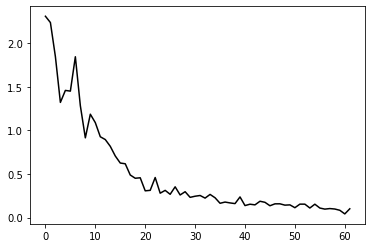

In [7]:
l1 = list(range(len(FedOGD_loss)))


plt.plot(l1, FedOGD_loss, 'black', label=r'OFedAvg ($\mathdefault{p=0.1}$)')


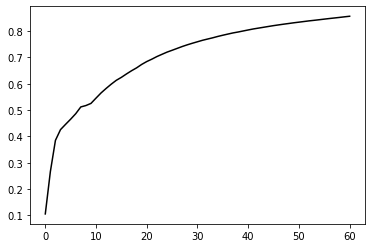

In [8]:
a1 = list(range(len(FedOGD_acc)))
a2 = list(range(len(OFedAvg_acc)))
plt.plot(a1, FedOGD_acc, 'black', label=r'OFedAvg ($\mathdefault{p=0.1}$)')
plt.plot(a2, OFedAvg_acc, 'red', label=r'OFedAvg ($\mathdefault{p=0.1}$)')

In [8]:
import pickle

with open(f"./FedOGD_acc.pkl","wb") as f:
    pickle.dump(FedOGD_acc, f)

with open(f"./FedOGD_loss.pkl","wb") as f:
    pickle.dump(FedOGD_loss, f)

In [7]:
FedOGD_acc

[0.105,
 0.169,
 0.415,
 0.535,
 0.565,
 0.596,
 0.649,
 0.712,
 0.691,
 0.785,
 0.839,
 0.809,
 0.814,
 0.821,
 0.787,
 0.845,
 0.883,
 0.885,
 0.923,
 0.897,
 0.899,
 0.942,
 0.919,
 0.921,
 0.9,
 0.925,
 0.925,
 0.915,
 0.943,
 0.926,
 0.938,
 0.92,
 0.934,
 0.944,
 0.942,
 0.943,
 0.96,
 0.935,
 0.955,
 0.944,
 0.961,
 0.944,
 0.941,
 0.942,
 0.955,
 0.943,
 0.945,
 0.946,
 0.959,
 0.943,
 0.955,
 0.968,
 0.954,
 0.969,
 0.962,
 0.974,
 0.967,
 0.966,
 0.984,
 0.974]

In [8]:
# evaluate

FedOGD[K].evaluate(x_train[0:100], y_train[0:100], batch_size = 1)


100/100 [==============================] - 0s 698us/step - loss: 0.1084 - sparse_categorical_accuracy: 0.0000e+00


[0.10835853219032288, 0.0]